# TDI Project Proposal
# Social Network Analysis for Animal Populations
Carson Bulgin - cbulgin@gmu.edu - Updated November 4, 2019

#Project Summary:

The adoption of Social Network Analysis (SNA), used most often for social media analysis is increasingly used for other scientific endeavors.  Collecting information on animals can involve long field study in hostile environments, and many interactions can occur when it is difficult to observe them.  Recently, deployment of unmanned aerial vehicles and increasingly smaller and more precise GPS location devices has allowed field researchers to collect more and continuous information on animal populations.  This work explores the application of SNA techniques to a 2012 study that resulted in a published paper in 2017 (Strandburg-Peshkin, A., et. al.) on the effect of environment and group decision making in a group of olive baboons (Papio anubis) in Mpala Research Centre in Laikipia, Kenya.

# Project Objectives:

Given a 24-hour period of highly accurage GPS data and demographic data on the Mpala baboons, determine if it is possible to make meaningful conclusions about the social structure and interactions in the group using python.  

* Task One: Acquire the data.  The data consists of two files: a reference file with the number, weight, age and gender for each baboon; and 24 hours worth of per-second tracking information (latitude/longitude) with a time stamp.  Load this data into python so it can be processed.

* Task Two: Baboons are interacting if they are within +/- 1 meter at the same time. The goal is to take the data and derive the number of meaningful interactions that ocurred between two baboons during the 24 hour period.  The baboon IDs will become network nodes, and the interactions will become the edges in the model.  
   
* Task Three:  Using python's SNA tools, construct a Social Network Analysis graph of the interactions.
    * Create two versions of the graph: one with all interactions, and one filtered by a meaningful value (e.g., more than 10 interactions)
    * Color code the filtered graph by animal gender and age.

* Task Four:  Calculate degree and betweeness centrality.  Display the results.

* Task Five:  Interpret the findings.  Are we able to determine social structure from the analysis?

Import everything we need in one place.

In [349]:
import os,sys
import csv
import numpy as np
import pandas as pd
import collections
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
myDir = '/users/chanb/'
sys.path.append( myDir )

# Task One: Data

Data pre-processing.  Two steps were required.  First, I filtered the data and selected only one (out of 14) days.  This yielded 631,652 rows.
Next, I had to normalize the date/time format to correct slight synchronization issues with the individual GPS devices.  For example: one recorded 04:33:15.998 and another recorded 04:33.16.001.  These both correspond to the same timestamp.  Day was discarded since my reduced dataset is all from the same day.

In [431]:
# Read in the location and demographic data.
# file formats: locdata is "time, longitude, latitude, baboon id"
#               demographics is "baboon_id, age class, weight, gender" and has a header in the first row.
geodata = pd.read_csv('baboons.csv')
demog = pd.read_csv('baboon_demographics.csv')
print (demog.head(5),"\n")
print (geodata.head(5),"\n")
print (geodata.tail(5),"\n")
print("\nNumber of records:",len(geodata))

   animal-id animal-life-stage  animal-mass animal-sex
0          1             adult        25000          m
1          2          subadult        20000          m
2          3             adult        28000          m
3          4             adult        16000          f
4          5          subadult         9000          m 

  datetime        lon       lat  id
0  3:00:44  36.922621  0.351424   5
1  3:00:44  36.923113  0.350387  25
2  3:00:44  36.922759  0.351076   4
3  3:00:44  36.923057  0.350483   9
4  3:00:45  36.922650  0.351402   5 

        datetime        lon       lat  id
631647  14:59:01  36.922614  0.351175   4
631648  14:59:01  36.922435  0.351288  11
631649  14:59:01  36.922458  0.351473  21
631650  14:59:01  36.922720  0.350948  25
631651  14:59:01  36.922594  0.351293   9 


Number of records: 631652


# Task Two: Calculate the Nodes and Edges for the Network.

In [502]:
# build the algortihm to determine if a is connected to b
# if two baboons are within 1 meter of each other, they are interacting
g = geodata.datetime.unique()
id2 = geodata.id.unique()
precision = 0.00001 # in Kenya, the location of the original study, 0.00001 lat and lon = 1 meter.
                    # the distance of a point of lat/lon varies depending on where you are in the world.
nodes_edges = []

In [503]:
g2 = geodata.datetime.unique()
g2.sort()
id2 = geodata.id.unique()
id2.sort()

In [504]:
len(g2)

43098

In [505]:
match_df = geodata[geodata.datetime == g2[0]]

In [506]:
match_df

,datetime,lon,lat,id
363480,10:00:00,36.915953,0.352028,4
363481,10:00:00,36.915956,0.351971,6
363482,10:00:00,36.915906,0.351986,31
363483,10:00:00,36.916125,0.351848,38
363484,10:00:00,36.916155,0.351863,1
363485,10:00:00,36.916160,0.351786,2
363486,10:00:00,36.915922,0.352000,20
363487,10:00:00,36.916158,0.351723,21
363488,10:00:00,36.916173,0.351666,7
363489,10:00:00,36.915982,0.352037,24


In [258]:
#This is the most critical code block in the project.
#Using a unique list of datetime values from geodata,
#it chunks the data set into small batches of records
#
#Because we know that the time has to match, we only need to compare
#locations within this data block for interactions.
#
#This takes about 15-20 minutes to execute on my machine for ~600,000 records.

j = 0
for i in range (0, len(g2)): #check each unique timestamp
    #print("i is:",i)
    match_df = geodata[geodata.datetime == g2[i]]
    np_match = np.array(match_df)
    #print (np_match,"\n")
    for j in range (0,len(np_match)):
        #check each unique id in the match dataframe
        #print("j is:",j)
        #print("np_match len is",len(np_match))
        #print("id is:",np_match[j][3])
        for k in range (0,len(np_match)):
            #print("k is:",k)
            #compare j location to every location in the dataframe, record matches
            if np_match[j][3] == np_match[k][3]:
                #print("The keys are the same, skipping...")
                pass # pass - we know dupes will match
            else:
                if ( np_match[j][1] < (np_match[k][1] + precision) and np_match[j][1] > (np_match[k][1] - precision)
                      and np_match[j][2] < (np_match[k][2] + precision) and np_match[j][2] > (np_match[k][2] - precision) ):
                    values = [np_match[j][3],np_match[k][3]]
                    nodes_edges.append(values)

Now we have a long list of id, id pairs that indicate an interaction.  Let's aggregate them so we can construct our SNA visuals.

In [369]:
print(len(nodes_edges))
nodes_edges_df = pd.DataFrame(nodes_edges, columns=['id', 'connection'])
counts = nodes_edges_df.groupby(nodes_edges_df.columns.tolist()).size().reset_index().\
    rename(columns={0:'weight'})

61448


In [370]:
counts

,id,connection,weight
0,1,2,245
1,1,3,13
2,1,4,215
3,1,5,151
4,1,6,446
5,1,7,224
6,1,9,62
7,1,10,80
8,1,11,99
9,1,15,57


Next, let's calculate some statistics and look at the processed data.

In [507]:
counts_mean = np.mean(counts.iloc[:]['weight'])
counts_std = np.std(counts.iloc[:]['weight'])

In [508]:
counts_mean, counts_std

(225.91176470588235, 221.39495818254431)

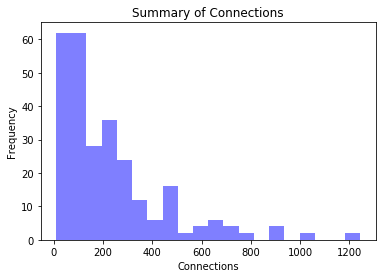

In [509]:
x = counts.iloc[:]['weight']
num_bins = 20
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Connections')
plt.ylabel('Frequency')
plt.title('Summary of Connections')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


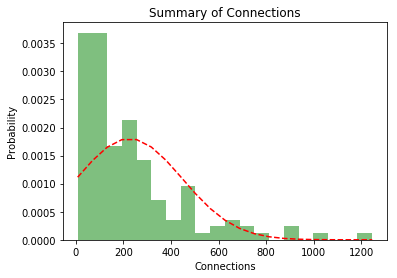

Mean is: 225.91176470588235
Standard deviation is: 221.39495818254431


In [510]:
num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='green', alpha=0.5)

# add a 'best fit' line
y = mlab.normpdf(bins, counts_mean, counts_std)
plt.plot(bins, y, 'r--')
plt.xlabel('Connections')
plt.ylabel('Probability')
plt.title('Summary of Connections')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()
print("Mean is:",counts_mean)
print("Standard deviation is:", counts_std)

There are a high percentage of connections that have a small weight, the more interesting nodes are those with many connections.  Let's filter out the less interesting nodes.  We'll explain why this is important later.

In [511]:
counts_reduced = counts[counts.weight >200]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


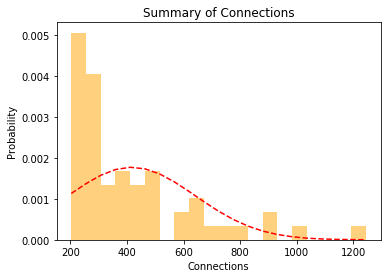

mean is: 416.36842105263156
standard deviation is: 225.4750642905001


In [512]:
x = counts_reduced.iloc[:]['weight']
counts_mean_r = np.mean(counts_reduced.iloc[:]['weight'])
counts_std_r = np.std(counts_reduced.iloc[:]['weight'])
num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='orange', alpha=0.5)

# add a 'best fit' line
y = mlab.normpdf(bins, counts_mean_r, counts_std_r)
plt.plot(bins, y, 'r--')
plt.xlabel('Connections')
plt.ylabel('Probability')
plt.title('Summary of Connections')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()
print('mean is:',counts_mean_r)
print('standard deviation is:',counts_std_r)

In [549]:
counts_reduced

,id,connection,weight
0,1,2,245
2,1,4,215
4,1,6,446
5,1,7,224
10,1,20,227
12,1,24,276
16,2,1,245
18,2,4,263
19,2,5,392
20,2,6,206


# Task Three: Let's build a graph!

Part One: A graph with all connections.

In [550]:
G1=nx.Graph()

In [551]:
for i in range (0,len(counts)):
    G1.add_edge(counts.iloc[i]['id'],counts.iloc[i]['connection'], weight= counts.iloc[i]['connection'])

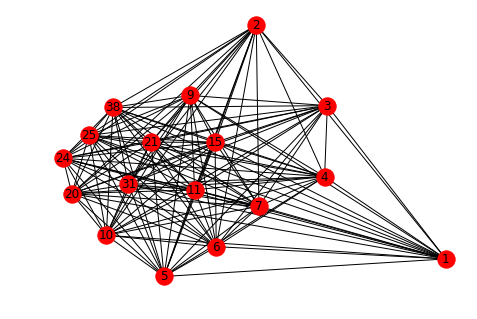

In [552]:
nx.draw(G1, with_labels = True)

In the unfiltered model, every node is connected to every node.  This isn't surprising.  Baboons are social animals and over the course of a day, it's expected that they would interact at least one time.  However this graph isn't all that interesting.  Social structure and importance is not discernable.

Part Two: A graph filtered by high-frequency interactions.

In [553]:
G2 = nx.Graph()

In [556]:
#Let's color code the visualization by gender and age.

g_color = []
#32fc43
#34b53f
#23752a
#3d9df7
#356b9e
#0c2e4f

for i in range (0, len(demog)):
    #print("Id:",demog.iloc[i]['animal-id'], "Age: ",demog.iloc[i]['animal-life-stage'], "Gender:", demog.iloc[i]['animal-sex'])
    if (demog.iloc[i]['animal-id'] == 3): #was filtered out
        #print("Skipping 3 due to filtering.")
        pass
    else:
        if demog.iloc[i]['animal-sex']== 'm':
            if demog.iloc[i]['animal-life-stage'] == 'juvenile':
                g_color.append('#3d9df7')
            elif demog.iloc[i]['animal-life-stage'] == 'subadult':
                g_color.append('#356b9e')
            elif demog.iloc[i]['animal-life-stage'] == 'adult':
                g_color.append('#0c2e4f')
        else:
            if demog.iloc[i]['animal-life-stage'] == 'juvenile':
                g_color.append('#32fc43')
            elif demog.iloc[i]['animal-life-stage'] == 'subadult':
                g_color.append('#34b53f')
            elif demog.iloc[i]['animal-life-stage'] == 'adult':
                g_color.append('#23752a')
        G2.add_node(demog.iloc[i]['animal-id'])

In [557]:
for i in range (0,len(counts_reduced)):
    G2.add_edge(counts_reduced.iloc[i]['id'],counts_reduced.iloc[i]['connection'], weight= counts_reduced.iloc[i]['connection'])

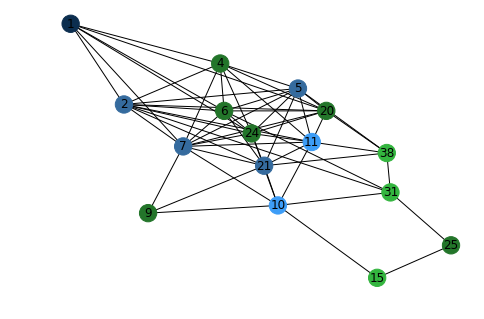

In [558]:
nx.draw(G2, node_color = g_color, with_labels = True)

# Task Four: Calculate Centrality

Degree centrality, a measure of which baboons have the highest average number of connections to the rest of the group.   
Betweenness centrality, a measure of centrality in a graph based on shortest paths. 

In [559]:
g2_dc = nx.algorithms.centrality.degree_centrality(G2)
g2_bc = nx.algorithms.centrality.betweenness_centrality(G2, weight='weight')


In [560]:
print("Degre Centality:\n")
for key, value in sorted(g2_dc.items(), key=lambda item: item[1], reverse = True):
    print("%s: %s" % (key, value))
print("\nBetweeness Centality:\n")
for key, value in sorted(g2_bc.items(), key=lambda item: item[1], reverse = True):
    print("%s: %s" % (key, value))

Degre Centality:

7: 0.7333333333333333
2: 0.6666666666666666
24: 0.6666666666666666
5: 0.6
6: 0.6
11: 0.6
20: 0.6
21: 0.6
4: 0.5333333333333333
10: 0.4666666666666667
1: 0.4
31: 0.3333333333333333
38: 0.3333333333333333
9: 0.2
15: 0.13333333333333333
25: 0.13333333333333333

Betweeness Centality:

2: 0.5333333333333334
1: 0.4238095238095238
7: 0.24761904761904763
5: 0.13333333333333336
10: 0.13333333333333336
31: 0.10476190476190478
15: 0.01904761904761905
4: 0.0
6: 0.0
9: 0.0
11: 0.0
20: 0.0
21: 0.0
24: 0.0
25: 0.0
38: 0.0


# Task Five: Results



After filtering the less significant relationships, we can observe the following:

Animal 7, a subadult male, is the most connected.  Animal 2, another subadult male, and animal 24, an adult female are the next most connected.
Animals 15 and 25 (subadult female and adult female) are the least connected.  Why do you think this is the case?

Animal 2 (who has high degree centrality) has the highest betweenness centrality by a significant margin.  This means that he is a social hub through which many of the troop share information.  There are a large number (over half) of the animals that have a zero betweenness centrality.  It is equally plausible that the nature of baboon social groups are loosely connected or that adults 4, 6, 20 and 24 are more independent.  

Animal 3 dropped out of the graph once we filtered it.  Perhaps a new joiner to the troop?  Other explanation?

There are several uses for this type of analysis.  For example, researchers in the field can pinpoint relationships for further study to reinforce or explain observed behavior.  Because the number of animals usually outnumber the number of researchers in the field, this allows continuous observation of social patterns and behavoir. 